In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import gdown
import joblib
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, ShuffleSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from keras.models import load_model
from keras import models
from scipy.stats import randint

Found 4800 images belonging to 4 classes.
Found 4800 images belonging to 4 classes.
Displaying 5 images per class from train dataset:


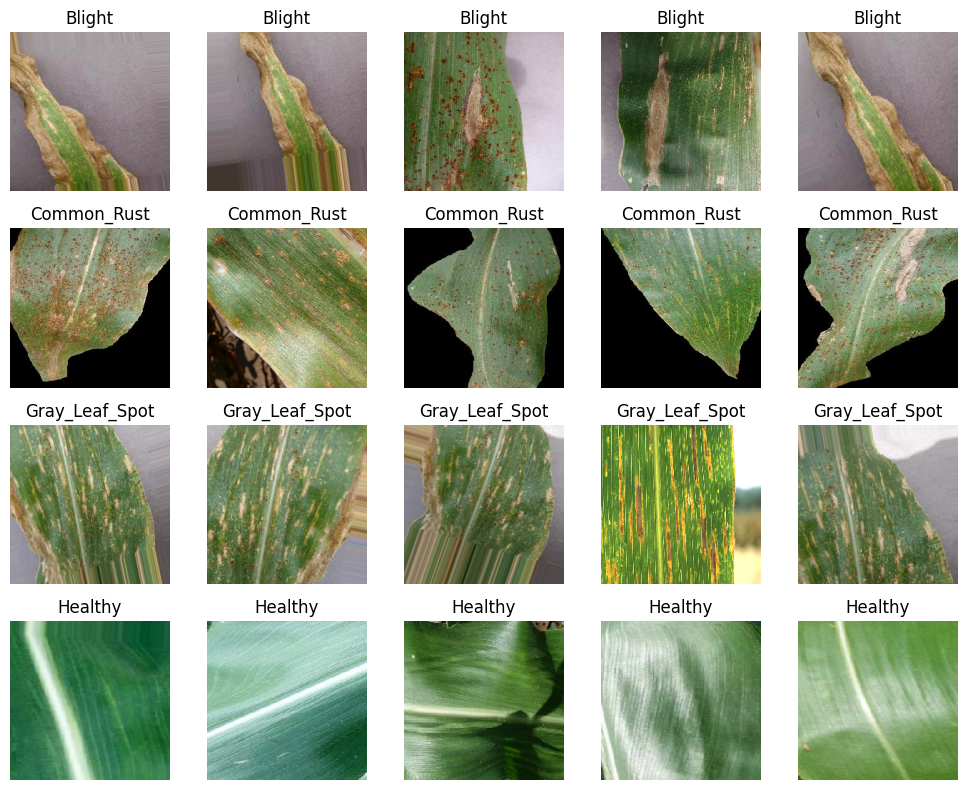

Displaying 5 images per class from test dataset:


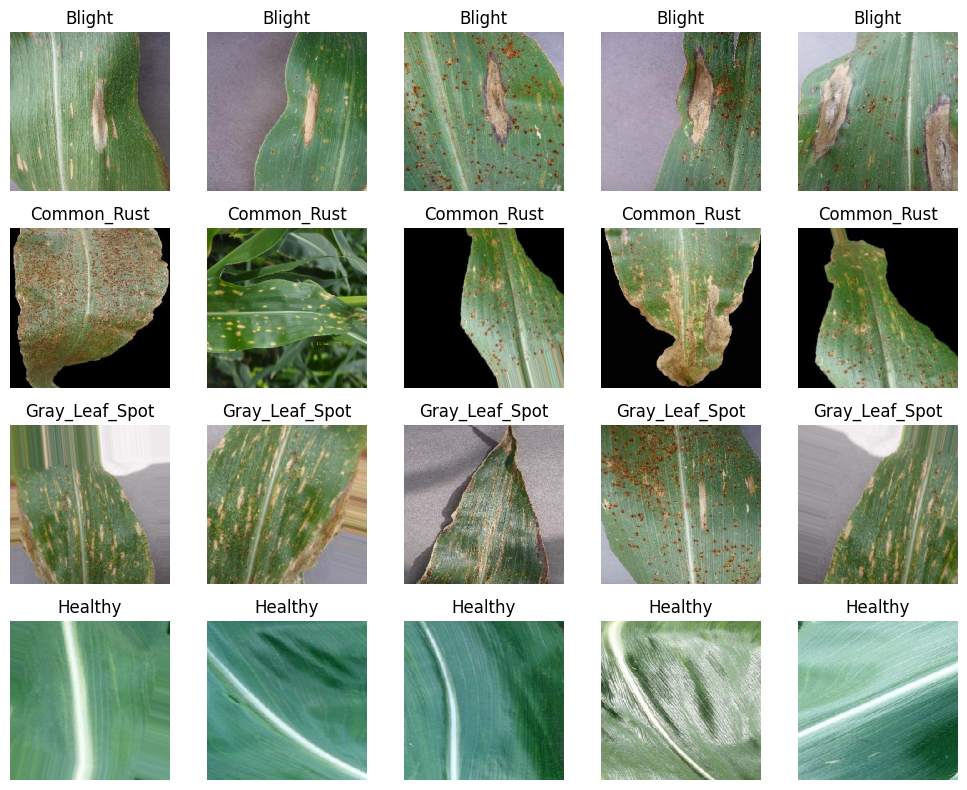

In [4]:
### Kode untuk mengakses data train dan data test

# Define paths
train_dir = '../../jagung-test/train3'
test_dir = '../../jagung-test/train3'

# Parameters
input_shape = (224, 224, 3)
batch_size = 32
num_classes = len(os.listdir(train_dir))  # Assuming number of classes is number of folders in train_dir

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Jangan shuffle data uji
)

# Function to display 5 images from each class
def display_images(generator, classes, num_images=5):
    fig, axes = plt.subplots(len(classes), num_images, figsize=(num_images * 2, len(classes) * 2))
    axes = axes.flatten()
    class_images = {cls: 0 for cls in classes}

    # Convert classes to a list for indexing
    class_list = list(classes)

    # Iterate through batches of images
    for batch_images, batch_labels in generator:
        for i, (img, lbl) in enumerate(zip(batch_images, batch_labels)):
            label = class_list[np.argmax(lbl)]
            if class_images[label] < num_images:
                ax = axes[class_list.index(label) * num_images + class_images[label]]
                ax.imshow(img)
                ax.set_title(label)
                ax.axis('off')
                class_images[label] += 1

            if all(count >= num_images for count in class_images.values()):
                plt.tight_layout()
                plt.show()
                return

# Display images from train dataset
print("Displaying 5 images per class from train dataset:")
display_images(train_generator, train_generator.class_indices.keys())

# Display images from test dataset
print("Displaying 5 images per class from test dataset:")
display_images(test_generator, test_generator.class_indices.keys())


In [5]:
### Kode untuk build single model

input_shape = (224, 224, 3)
batch_size = 32

resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction = Dense(num_classes, activation='softmax')
model = tf.keras.Sequential([
    resnet50,
    global_average_layer,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(224, activation='relu'),
    prediction
])

In [6]:
### Kode untuk train single model

resnet50.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet = model.fit(train_generator, epochs=10, validation_data=test_generator,
                                   verbose=1)

Epoch 1/10


d:\SEMESTER 7\BISMILLAH SKRIPSI\sistem\test-model\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 646s 4s/step - accuracy: 0.2813 - loss: 1.5227 - val_accuracy: 0.4604 - val_loss: 1.2289
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 776s 5s/step - accuracy: 0.4058 - loss: 1.2519 - val_accuracy: 0.4533 - val_loss: 1.0597
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 724s 5s/step - accuracy: 0.4573 - loss: 1.1340 - val_accuracy: 0.4542 - val_loss: 1.0411
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 791s 5s/step - accuracy: 0.4780 - loss: 1.0814 - val_accuracy: 0.4935 - val_loss: 0.9551
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 807s 5s/step - accuracy: 0.4995 - loss: 1.0628 - val_accuracy: 0.6458 - val_loss: 0.9146
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 811s 5s/step - accuracy: 0.5500 - loss: 0.9810 - val_accuracy: 0.6871 - val_loss: 0.8237
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 812s 5s/step - accuracy: 0.5500 - loss: 0.9640 - val_accuracy: 0.6708 - val_loss: 0.7725
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 817s 5s/step - accuracy: 0.5721 - loss: 0.9321 - val_accuracy: 0.712

In [ ]:
### Kode untuk train single model dengan transfer leaning

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_save_path = '/content/drive/My Drive/jagung_test/model_baru_3_resnet.h5'
model_checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

resnet50.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training dengan fine-tuning
history_resnet_finetune = model.fit(train_generator, epochs=10, validation_data=test_generator, verbose=1, callbacks=[early_stopping, model_checkpoint])

# Save trained model
model.save(model_save_path)

print("Model training completed and saved to Google Drive:", model_save_path)

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Plot training & validation loss dan accuracy
history = history_resnet_finetune.history

plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Generate predictions dan plot confusion matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("\nClassification Report:\n", class_report)

# Calculate dan display additional metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch 1/10


d:\SEMESTER 7\BISMILLAH SKRIPSI\sistem\test-model\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 423s 5s/step - accuracy: 0.4795 - loss: 5.5962 - val_accuracy: 0.3019 - val_loss: 5.4472 - learning_rate: 1.0000e-04
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 446s 6s/step - accuracy: 0.6740 - loss: 4.5922 - val_accuracy: 0.2846 - val_loss: 5.7387 - learning_rate: 1.0000e-04
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 437s 5s/step - accuracy: 0.7384 - loss: 3.9419 - val_accuracy: 0.3043 - val_loss: 7.2143 - learning_rate: 1.0000e-04
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 447s 6s/step - accuracy: 0.7291 - loss: 3.4848 - val_accuracy: 0.2918 - val_loss: 14.2639 - learning_rate: 1.0000e-04
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 441s 5s/step - accuracy: 0.7651 - loss: 3.0786 - val_accuracy: 0.5430 - val_loss: 4.5040 - learning_rate: 5.0000e-05
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 443s 6s/step - accuracy: 0.8015 - loss: 2.8303 - val_accuracy: 0.3502 - val_loss: 9.3017 - learning_rate: 5.0000e-05
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 434s 5s/step - accuracy: 0.8162 - loss: 2.

In [6]:
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction = Dense(num_classes, activation='softmax')
model = tf.keras.Sequential([
    efficientnet,
    global_average_layer,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(224, activation='relu'),
    prediction
])


In [ ]:
efficientnet.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])

history_efficientnet = model.fit(train_generator, epochs=10, validation_data=test_generator,
                                 verbose=1)


In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_save_path_efficientnet = '/content/drive/My Drive/jagung_test/model_baru_3_efficientnet.h5'
model_checkpoint = ModelCheckpoint(
    model_save_path_efficientnet,
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

efficientnet.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training dengan fine-tuning
history_efficientnet_finetune = model.fit(train_generator, epochs=10, validation_data=test_generator,
                                 verbose=1, callbacks=[early_stopping, model_checkpoint])
# Save the trained model
model.save(model_save_path_efficientnet)

print("Model training completed and saved to Google Drive:", model_save_path_efficientnet)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 1149s 12s/step - accuracy: 0.7760 - loss: 0.6960 - val_accuracy: 0.2774 - val_loss: 2.4509 - learning_rate: 0.0010
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9224 - loss: 0.2445 
Training stopped as training accuracy reached 90.00%
79/79 ━━━━━━━━━━━━━━━━━━━━ 887s 11s/step - accuracy: 0.9224 - loss: 0.2443 - val_accuracy: 0.2774 - val_loss: 2.8636 - learning_rate: 0.0010


In [8]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Plot training & validation loss dan accuracy
history = history_efficientnet_finetune.history

plt.figure(figsize=(12, 4))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Generate predictions dan plot confusion matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("\nClassification Report:\n", class_report)

# Calculate dan display additional metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


53/53 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step
Ensemble Model Accuracy: 1.0


['D:/SEMESTER 7/BISMILLAH SKRIPSI/jagung-test/model_ensemble.pkl']

In [ ]:
from keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from scipy.stats import randint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd

# Load pre-trained models
model_save_path = '/content/drive/My Drive/jagung_test/model_baru_3_ensemble.h5'
resnet_model_path = '/content/drive/My Drive/jagung_test/model_baru_3_resnet.h5'
efficientnet_model_path = '/content/drive/My Drive/jagung_test/model_baru_3_efficientnet.h5'

resnet_model = load_model(resnet_model_path)
efficientnet_model = load_model(efficientnet_model_path)

# Extract features using ResNet and EfficientNet
resnet_features_test = resnet_model.predict(test_generator)
efficientnet_features_test = efficientnet_model.predict(test_generator)

# Combine features
ensemble_features_test = np.concatenate((resnet_features_test, efficientnet_features_test), axis=1)

# Mengambil labels dari data test
y_test = test_generator.classes

# Split data untuk data train dan data test
X_train, X_val, y_train, y_val = train_test_split(ensemble_features_test, y_test, test_size=0.2, random_state=42)

# Define parameter untuk RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_distributions,
                                   n_iter=100,
                                   scoring='accuracy',
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1) 

# Fit RandomizedSearchCV pada data train
random_search.fit(X_train, y_train)

# Mengambil best parameters 
best_params = random_search.best_params_
best_model = random_search.best_estimator_


y_pred_val = best_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
# Evaluate best model pada data test
y_pred_test = best_model.predict(ensemble_features_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy of Best Model:", accuracy_test)

# Confusion matrix best model
classes = ['Gray_Leaf_Spot', 'Common_Rust', 'Blight', 'Healthy']
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Best Model')
plt.show()

# Classification report best model
report = classification_report(y_test, y_pred_test, target_names=classes)
print("\nClassification Report:\n", report)

# Save best model
joblib.dump(best_model, model_save_path)
print("Best model training completed and saved to Google Drive.", model_save_path)

# Convert the cv_results_ to a DataFrame
results = pd.DataFrame(random_search.cv_results_)

# Learning Curve
plt.figure(figsize=(12, 6))
plt.plot(results['mean_test_score'], label='Mean Test Score')
plt.plot(results['mean_train_score'], label='Mean Train Score')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Print the best parameters
print("Best parameters found:", best_params)


# Add an iteration column to track the n_iter
results['iteration'] = results.index

# Sort the results by mean_test_score in descending order to get the highest score first
sorted_results = results.sort_values(by='mean_test_score', ascending=False)

# Display the iteration number and corresponding mean_test_score
print("Iteration with the highest accuracy:")
print(sorted_results[['iteration', 'mean_test_score', 'std_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_bootstrap']].head(1))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ambil 10 indeks acak dari data uji
# np.random.seed(42)  # Untuk hasil yang konsisten
random_indices = np.random.choice(len(ensemble_features_test), size=10, replace=False)
X_samples = ensemble_features_test[random_indices]
y_samples = y_test[random_indices]

# Ambil gambar yang sesuai dari test_generator
images_samples = []
for idx in random_indices:
    batch_idx = idx // test_generator.batch_size
    image_idx = idx % test_generator.batch_size
    images_samples.append(test_generator[batch_idx][0][image_idx])

# Prediksi dengan model terbaik
y_pred_samples = best_model.predict(X_samples)
y_pred_proba = best_model.predict_proba(X_samples)

# Tampilkan hasil prediksi bersama dengan gambar
classes = ['Gray_Leaf_Spot', 'Common_Rust', 'Blight', 'Healthy']

plt.figure(figsize=(20, 10))
for i in range(len(X_samples)):
    actual_class = classes[y_samples[i]]
    predicted_class = classes[y_pred_samples[i]]
    confidence = y_pred_proba[i][y_pred_samples[i]]

    # Tentukan warna teks berdasarkan kesesuaian prediksi dengan actual
    text_color = 'green' if actual_class == predicted_class else 'red'

    plt.subplot(2, 5, i+1)
    plt.imshow(images_samples[i], cmap='gray')  # Sesuaikan sesuai format gambar
    plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.4f}", color=text_color)
    plt.axis('off')

plt.tight_layout()
plt.show()
